In [1]:
import pandas as pd
import numpy as np
from transformers import AutoModel, AutoTokenizer
import seaborn as sns
import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from scipy import spatial
import scipy
tqdm.pandas()

In [2]:
class CONFIG:
    relavent_tags = ['Science', "Machine Learning", "Artificial Intelligence", "Health", "Coronavirus"]
    max_len = 512
    model_name = "../input/pretrained-medium-roberta-distill/checkpoint-1000"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64

In [3]:
data = pd.read_csv("../input/medium-articles/medium_articles.csv")
print(f"Data has {len(data)} rows")
data.head()

Data has 192368 rows


,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."


In [4]:
def RemoveNewLines(text):
    text = text.replace("\n", " ")
    return text

In [5]:
def CheckTag(tags):
    for tag in CONFIG.relavent_tags:
        if tag in eval(tags):
            return True
    return False

In [6]:
data["contains_tag"] = data["tags"].progress_apply(CheckTag)
data = data[data["contains_tag"] == True]
data["text"] = data["text"].progress_apply(RemoveNewLines)
data["tokens"] = data["text"].progress_apply(str.split)
data["text_len"] = data["tokens"].progress_apply(len)

  0%|          | 0/192368 [00:00<?, ?it/s]

  0%|          | 0/14260 [00:00<?, ?it/s]

  0%|          | 0/14260 [00:00<?, ?it/s]

  0%|          | 0/14260 [00:00<?, ?it/s]

<AxesSubplot:xlabel='text_len', ylabel='Count'>

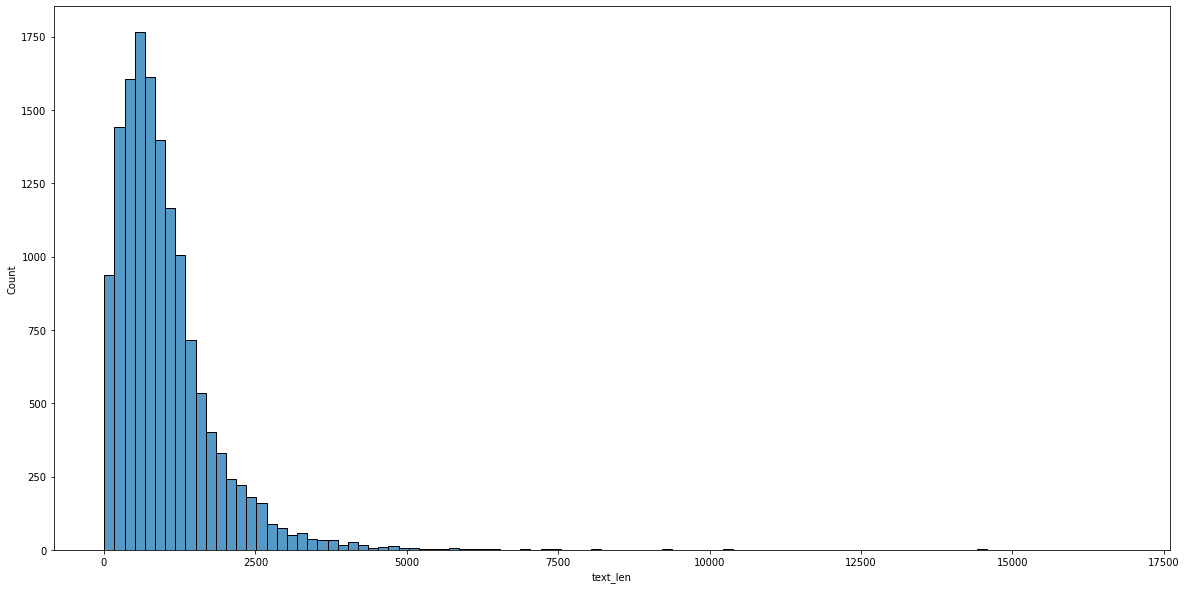

In [7]:
plt.figure(figsize=(20, 10))
sns.histplot(data['text_len'], bins=100)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("../input/huggingface-roberta-variants/distilroberta-base/distilroberta-base")
model = AutoModel.from_pretrained(CONFIG.model_name).to(CONFIG.device)

Some weights of the model checkpoint at ../input/pretrained-medium-roberta-distill/checkpoint-1000 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../input/pretrained-medium-roberta-distill/checkpoint-1000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stre

In [9]:
###https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently
def MeanPooling(last_hidden_state, attention_mask):
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
    sum_mask = input_mask_expanded.sum(1)
    sum_mask = torch.clamp(sum_mask, min=1e-9)
    mean_embeddings = sum_embeddings / sum_mask
    return mean_embeddings

In [10]:
def prepare_text(text):
    example = tokenizer(text, max_length=CONFIG.max_len, padding="max_length", truncation=True)
    example["input_ids"] = torch.tensor(example["input_ids"])
    example["attention_mask"] = torch.tensor(example["attention_mask"])
    return example

In [11]:
class SimilarityDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.texts = texts
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        example = prepare_text(text)
        return example

In [12]:
dataset = SimilarityDataset(data["text"].values)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=CONFIG.batch_size, num_workers=2, shuffle=False)

In [13]:
embeddings = []
for example in tqdm(dataloader):
    example["input_ids"] = torch.tensor(example["input_ids"]).to(CONFIG.device)
    example["attention_mask"] = torch.tensor(example["attention_mask"]).to(CONFIG.device)
    with torch.no_grad():
        embedding = model(**example)
        output = MeanPooling(embedding["last_hidden_state"], example["attention_mask"])
    for sample in output:
        embeddings.append(sample.detach().cpu().numpy())
embeddings = np.array(embeddings)

  0%|          | 0/223 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [14]:
np.save("medium_embeddings.npy", embeddings)